<a href="https://colab.research.google.com/github/siddley1001/SalaryPrediction/blob/master/Pipeline_Base_Models_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b>GOAL</b>: Train and Tune ML Models to predict Salary outputs from Features

# Table of contents | Summary
1. [<i>Import</i> Libraries](#libs)
2. [<i>Load</i> TRAIN, VALID, & TEST data](#load)
3. [<i>Create</i> Helper Functions](#helpers)
4. [*Implement* and *score* models: **loss, visualize feature weights, and save model(.pkl)**](#fitscore)
    - [Linear Regression](#lr)
    - [Random Forest](#rf)
    - [Gradient Boosting Regressor](#gbr)
    - [LightGBM Regressor](#lgbr)
    - [XGBR](#xgbr)
5. [<i>Visualize</i> Base Model scores](#base)
6. [<i>Store</i> Base Models in a Pickle format](#pickle)

## 1. <i>Import</i> Libraries <a name = "libs"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns
import plotly.express as px
import sklearn
import warnings
import pickle
import eli5
import re


#Import Various Regression models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


#Import pipeline components from Scikit Learn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.utils.validation import check_is_fitted
from sklearn.externals import joblib

warnings.filterwarnings('ignore', category= FutureWarning)

__author__ = "Sid Vanam"
__email__ = "vanamsid@gmail.com"

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be in

In [2]:
sns.set_style('whitegrid')

### Define Path Strings 

In [3]:
PATH = '/content/drive/My Drive/Salary Prediction Project'
PIPE1 = '/Joblib Pipelines/Pipeline1/'
PIPE2 = '/Joblib Pipelines/Pipeline2/'

## 2. <i>Load</i> TRAIN, VALID, & TEST data <a name = "load">

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
'''Read Train Data'''
with open(PATH + '/Pickle Data/TRAIN_X.pkl', 'rb') as temp0:
    X_train = pickle.load(temp0)
with open(PATH + '/Pickle Data/TRAIN_Y.pkl', 'rb') as temp1:
    y_train = pickle.load(temp1)

In [6]:
'''Read Validation Data'''
with open(PATH + '/Pickle Data/VALID_X.pkl', 'rb') as temp2:
    X_valid = pickle.load(temp2)
with open(PATH + '/Pickle Data/VALID_Y.pkl', 'rb') as temp3:
    y_valid = pickle.load(temp3)

In [7]:
'''Read Test Data'''
with open(PATH + '/Pickle Data/TEST_X.pkl', 'rb') as temp4:
    X_test = pickle.load(temp4)
with open(PATH + '/Pickle Data/TEST_Y.pkl', 'rb') as temp5:
    y_test = pickle.load(temp5)

## 3. <i>Create</i> Helper Functions <a name= "helpers">

In [8]:
def fitscore(pipeline, X_train, y_train, X_test, y_test, cv):
    ''' Fit pipeline on Training data and return the mean of the cross_val_score from the test/validation data'''    
    pipeline.fit(X_train, y_train)
    return -1* cross_val_score(pipeline, X_test, y_test, cv= cv, scoring = 'neg_mean_squared_error').mean()

def convert_objectcols(df, transform = True):
    '''
    "transform" parameter: used to label encode features
    False- converts it into category and True- transforms it with label Encoder
    '''
    df_copy = df.copy()
    
    if transform == False:
        for column in df_copy.columns:
            if df_copy[column].dtypes == 'O':
                df_copy[column] = df_copy[column].astype('category')
            else:
                pass
        return df_copy
    
    elif transform == True:
        for column in df_copy.columns:
            if df_copy[column].dtypes == 'O':
                df_copy[column] = le.fit_transform(df_copy[column])
            else:
                pass
        return df_copy

In [9]:
class FeatureImportance:
    """
    Extract & Plot the Feature Names & Importance Values from a Scikit-Learn Pipeline.
    
    The input is a Pipeline that STARTS with a ColumnTransformer & ENDS with a regression or classification model. 
    As intermediate steps, the Pipeline can have any number or no instances from sklearn.feature_selection.
    Note: 
    If the ColumnTransformer contains Pipelines and if one of the transformers in the Pipeline is adding completely new columns, 
    it must come last in the pipeline. For example, OneHotEncoder, MissingIndicator & SimpleImputer(add_indicator=True) add columns 
    to the dataset that didn't exist before, so there should come last in the Pipeline.
    
    
    Parameters
    ----------
    pipeline : a Scikit-learn Pipeline class where the ColumnTransformer is the first element and model estimator is the last element
    verbose : a boolean. Whether to print all of the diagnostics. Default is False.
    
    Attributes
    __________
    column_transformer_features :  A list of the feature names created by the ColumnTransformer prior to any selectors being applied
    transformer_list : A list of the transformer names that correspond with the `column_transformer_features` attribute
    discarded_features : A list of the features names that were not selected by a sklearn.feature_selection instance.
    discarding_selectors : A list of the selector names corresponding with the `discarded_features` attribute
    feature_importance :  A Pandas Series containing the feature importance values and feature names as the index.    
    plot_importances_df : A Pandas DataFrame containing the subset of features and values that are actually displaced in the plot. 
    feature_info_df : A Pandas DataFrame that aggregates the other attributes. The index is column_transformer_features. The transformer column contains the transformer_list.
        value contains the feature_importance values. discarding_selector contains discarding_selectors & is_retained is a Boolean indicating whether the feature was retained.
    
    """
    def __init__(self, pipeline, verbose=False):
        self.pipeline = pipeline
        self.verbose = verbose


    def get_feature_names(self, verbose=None):  

        """
        Get the column names from the a ColumnTransformer containing transformers & pipelines
        Parameters
        ----------
        verbose : a boolean indicating whether to print summaries. 
            default = False
        Returns
        -------
        a list of the correct feature names
        Note: 
        If the ColumnTransformer contains Pipelines and if one of the transformers in the Pipeline is adding completely new columns, 
        it must come last in the pipeline. For example, OneHotEncoder, MissingIndicator & SimpleImputer(add_indicator=True) add columns 
        to the dataset that didn't exist before, so there should come last in the Pipeline.
        Inspiration: https://github.com/scikit-learn/scikit-learn/issues/12525 
        """

        if verbose is None:
            verbose = self.verbose
            
        if verbose: print('''\n\n---------\nRunning get_feature_names\n---------\n''')
        
        column_transformer = self.pipeline[0]        
        assert isinstance(column_transformer, ColumnTransformer), "Input isn't a ColumnTransformer"
        check_is_fitted(column_transformer)

        new_feature_names, transformer_list = [], []

        for i, transformer_item in enumerate(column_transformer.transformers_): 
            
            transformer_name, transformer, orig_feature_names = transformer_item
            orig_feature_names = list(orig_feature_names)
            
            if verbose: 
                print('\n\n', i, '. Transformer/Pipeline: ', transformer_name, ',', 
                      transformer.__class__.__name__, '\n')
                print('\tn_orig_feature_names:', len(orig_feature_names))

            if transformer == 'drop':
                continue
                
            if isinstance(transformer, Pipeline):
                # if pipeline, get the last transformer in the Pipeline
                transformer = transformer.steps[-1][1]
            if hasattr(transformer, 'get_feature_names'):
                if 'input_features' in transformer.get_feature_names.__code__.co_varnames:
                    names = list(transformer.get_feature_names(orig_feature_names))
                else:
                    names = list(transformer.get_feature_names())

            elif hasattr(transformer,'indicator_') and transformer.add_indicator:
                # is this transformer one of the imputers & did it call the MissingIndicator?
                missing_indicator_indices = transformer.indicator_.features_
                missing_indicators = [orig_feature_names[idx] + '_missing_flag'\
                                      for idx in missing_indicator_indices]

                names = orig_feature_names + missing_indicators
            elif hasattr(transformer,'features_'):
                # is this a MissingIndicator class? 
                missing_indicator_indices = transformer.features_
                missing_indicators = [orig_feature_names[idx] + '_missing_flag'\
                                      for idx in missing_indicator_indices]
            else:
                names = orig_feature_names
            if verbose: 
                print('\tn_new_features:', len(names))
                print('\tnew_features:\n', names)
            new_feature_names.extend(names)
            transformer_list.extend([transformer_name] * len(names))
        self.transformer_list, self.column_transformer_features = transformer_list,\
                                                                    new_feature_names
        return new_feature_names

    
    def get_selected_features(self, verbose=None):
        """
        Get the Feature Names that were retained after Feature Selection (sklearn.feature_selection)
        Parameters
        ----------
        verbose : a boolean indicating whether to print summaries. default = False
        Returns
        -------
        a list of the selected feature names
        """

        if verbose is None:
            verbose = self.verbose

        assert isinstance(self.pipeline, Pipeline), "Input isn't a Pipeline"
        features = self.get_feature_names()
        
        if verbose: print('\n\n---------\nRunning get_selected_features\n---------\n')
            
        all_discarded_features, discarding_selectors = [], []

        for i, step_item in enumerate(self.pipeline.steps[:]):
            step_name, step = step_item

            if hasattr(step, 'get_support'):
                if verbose: print('\nStep ', i, ": ", step_name, ',', 
                                  step.__class__.__name__, '\n')
                    
                check_is_fitted(step)
                feature_mask_dict = dict(zip(features, step.get_support()))
                features = [feature for feature, is_retained in feature_mask_dict.items()\
                            if is_retained]
                                         
                discarded_features = [feature for feature, is_retained in feature_mask_dict.items()\
                                      if not is_retained]
                
                all_discarded_features.extend(discarded_features)
                discarding_selectors.extend([step_name] * len(discarded_features))
                
                if verbose: 
                    print(f'\t{len(features)} retained, {len(discarded_features)} discarded')
                    if len(discarded_features) > 0:
                        print('\n\tdiscarded_features:\n\n', discarded_features)

        self.discarded_features, self.discarding_selectors = all_discarded_features,\
                                                                discarding_selectors
        return features

    def get_feature_importance(self):
        
        """
        Creates a Pandas Series where values are the feature importance values from the model and feature names are set as the index. 
        
        This Series is stored in the `feature_importance` attribute.
        Returns
        -------
        A pandas Series containing the feature importance values and feature names as the index.
        
        """
        
        assert isinstance(self.pipeline, Pipeline), "Input isn't a Pipeline"

        features = self.get_selected_features()
             
        assert hasattr(self.pipeline[-1], 'feature_importances_'),\
            "The last element in the pipeline isn't an estimator with a feature_importances_ attribute"
        
        importance_values = self.pipeline[-1].feature_importances_
        
        assert len(features) == len(importance_values),\
            "The number of feature names & importance values doesn't match"
        
        feature_importance = pd.Series(importance_values, index=features)
        self.feature_importance = feature_importance
        
        # create feature_info_df
        column_transformer_df =\
            pd.DataFrame(dict(transformer=self.transformer_list),
                         index=self.column_transformer_features)

        discarded_features_df =\
            pd.DataFrame(dict(discarding_selector=self.discarding_selectors),
                         index=self.discarded_features)

        importance_df = self.feature_importance.rename('value').to_frame()

        self.feature_info_df = \
            column_transformer_df\
            .join([importance_df, discarded_features_df])\
            .assign(is_retained = lambda df: ~df.value.isna())        


        return feature_importance
    
    def plot(self, top_n_features=100, rank_features=True, max_scale=True, 
             display_imp_values=True, display_imp_value_decimals=1,
             height_per_feature=25, orientation='h', width=750, height=None, 
             str_pad_width=15, yaxes_tickfont_family='Courier New', 
             yaxes_tickfont_size=15):
        """
        Plot the Feature Names & Importances 
        Parameters
        ----------
        top_n_features : the number of features to plot, default is 100
        rank_features : whether to rank the features with integers, default is True
        max_scale : Should the importance values be scaled by the maximum value & mulitplied by 100?  Default is True.
        display_imp_values : Should the importance values be displayed? Default is True.
        display_imp_value_decimals : If display_imp_values is True, how many decimal places should be displayed. Default is 1.
        height_per_feature : if height is None, the plot height is calculated by top_n_features * height_per_feature. 
        This allows all the features enough space to be displayed
        orientation : the plot orientation, 'h' (default) or 'v'
        width :  the width of the plot, default is 500
        height : the height of the plot, the default is top_n_features * height_per_feature
        str_pad_width : When rank_features=True, this number of spaces to add between the rank integer and feature name. 
            This will enable the rank integers to line up with each other for easier reading. 
            Default is 15. If you have long feature names, you can increase this number to make the integers line up more.
            It can also be set to 0.
        yaxes_tickfont_family : the font for the feature names. Default is Courier New.
        yaxes_tickfont_size : the font size for the feature names. Default is 15.
        Returns
        -------
        plot
        """
        if height is None:
            height = top_n_features * height_per_feature
            
        # prep the data
        
        all_importances = self.get_feature_importance()
        n_all_importances = len(all_importances)
        
        plot_importances_df =\
            all_importances\
            .nlargest(top_n_features)\
            .sort_values()\
            .to_frame('value')\
            .rename_axis('feature')\
            .reset_index()
                
        if max_scale:
            plot_importances_df['value'] = \
                                plot_importances_df.value.abs() /\
                                plot_importances_df.value.abs().max() * 100
            
        self.plot_importances_df = plot_importances_df.copy()
        
        if len(all_importances) < top_n_features:
            title_text = 'All Feature Importances'
        else:
            title_text = f'Top {top_n_features} (of {n_all_importances}) Feature Importances'       
        
        if rank_features:
            padded_features = \
                plot_importances_df.feature\
                .str.pad(width=str_pad_width)\
                .values
            
            ranked_features =\
                plot_importances_df.index\
                .to_series()\
                .sort_values(ascending=False)\
                .add(1)\
                .astype(str)\
                .str.cat(padded_features, sep='. ')\
                .values

            plot_importances_df['feature'] = ranked_features
        
        if display_imp_values:
            text = plot_importances_df.value.round(display_imp_value_decimals)
        else:
            text = None

        # create the plot 
        
        fig = px.bar(plot_importances_df, 
                     x='value', 
                     y='feature',
                     orientation=orientation, 
                     width=width, 
                     height=height,
                     text=text)
        fig.update_layout(title_text=title_text, title_x=0.5) 
        fig.update(layout_showlegend=False)
        fig.update_yaxes(tickfont=dict(family=yaxes_tickfont_family, 
                                       size=yaxes_tickfont_size),
                         title='')
        fig.show()

In [10]:
def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
        
    Code found on https://johaupt.github.io/scikit-learn/tutorial/python/data%20processing/ml%20pipeline/model%20interpretation/columnTransformer_feature_names.html
    """

    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == sklearn.pipeline.Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

In [11]:
def palette(pipeline):
    ''' create a dictionary that maps a pipeline's features to colors'''
    color_dict = {}
    for name in get_feature_names(pipeline[0]):
        if 'ohe' in name:
            if 'x0' in name: 
                color_dict[name] = '#e6d5b8'        #beige; companyId
            elif 'x1' in name: 
                color_dict[name] = '#a20a0a'        #daredevil -- red; major
            elif 'x2' in name: 
                color_dict[name] = '#799351'        #olive -- green; industry
            elif 'x3' in name: 
                color_dict[name] = '#f9813a'        #orange; jobType
            elif 'x4' in name: 
                color_dict[name] = "#edc988"        #maize -- yellow; degree
        
        elif 'oe' in name:
            if 'jobType' in name:
                color_dict[name] = '#f9813a'        #orange; jobType
            elif 'degree' in name:
                color_dict[name] = "#edc988"        #maize -- yellow; degree
        else:
            color_dict[name] = '#a05344'            #brown; Numerical features
    return color_dict

def gen_legendpatch():
    '''Creates a patch with a dictionary for the visualization'''
    legend = {}
    legend['degree'] = '#edc988'
    legend['jobType'] = '#f9813a'
    legend['numerical_categories'] = '#a05344'
    legend['major'] = '#a20a0a'
    legend['industry'] = '#799351'
    legend['companyId'] = '#e6d5b8'
    
    patches = [mpl.patches.Patch(label = k, color = v, ) for k,v in legend.items()]
    return patches

In [12]:
def feature_vizz(pipeline, top =10):
    '''Visualizes most important features in a barplot
        - get table of feature & weights
        - get indices as ints (by stripping original feature values)
        - get feature names (replace afterwards with time)
        - set feature as the index
        - plot as barh to visualize
        ============================
        top: number of features to display
    '''
    patch = gen_legendpatch()
    
    #Check to see if the pipeline has a "Linear Regression" model
    if str(type(pipeline[1]).__name__) == 'LinearRegression':
        #Create positive and negative tables to compare side by side
        f, ax = plt.subplots(2,1, figsize=(20, 20))

        table = eli5.explain_weights_df(pipeline[1])
        feature_names = get_feature_names(pipeline[0])

        #drop <bias> feature from total table
        table = table.drop(0, axis= 'index')
        table.reset_index().drop('index', axis =1)

#         Plot positives on ax[1]
        pos_tab = table.loc[table['weight'] > 0]

        #Get indices from respective feature columns
        pos_indices = pos_tab['feature'].apply(lambda x: x.split('x')[-1])
        pos_indices = pos_indices.astype(int)
        
        #fill in feature column with feature names
        pos_tab['feature'] = np.array([feature_names[i] for i in pos_indices])
        pos_tab.set_index('feature')
        
        ##Deploy Visualization1
        pal1 = palette(pipeline)
        ax[1].set_title('Linear Regression Features with Positive influence in Predicting Salary', 
                        fontdict = {'fontsize': 25})
        ax[1] = sns.barplot(y= 'feature', x= 'weight', data= pos_tab.head(top), palette= pal1, ax = ax[1])
#         Plot negatives on ax[0]
        neg_tab = table.loc[table['weight'] < 0]

        #Get indices from respective feature columns
        neg_indices = neg_tab['feature'].apply(lambda x: x.split('x')[-1])
        neg_indices = neg_indices.astype(int)

        #fill in feature column with feature names
        neg_tab['feature'] = np.array([feature_names[i] for i in neg_indices])     
        neg_tab.set_index('feature')
        
        
        ##Deploy Visualization2
        pal2 = palette(pipeline)
        ax[0].set_title('Linear Regression Features with Negative influence in Predicting Salary', 
                        fontdict = {'fontsize': 25})
        ax[0] = sns.barplot(y= 'feature', x= 'weight', data= neg_tab.tail(top), palette= pal2, ax = ax[0])
        
        #Scale both graphs
        for ax in f.axes:
            plt.sca(ax)
            plt.legend(handles = patch, handlelength = 4, labelspacing = 0.75, fontsize = 'x-large')
            plt.rcParams["axes.labelsize"] = 20
            plt.xticks(fontsize= 16)
            plt.yticks(fontsize= 18)   
        return ax                    
        
    elif str(type(pipeline[1]).__name__) == 'LGBMRegressor':
       
        table = eli5.explain_weights_df(pipeline[1])
        feature_names = get_feature_names(pipeline[0])
    
        #Get indices from feature column of the table
        indices = table['feature'].apply(lambda x: x.split('_')[-1])
        indices = indices.reset_index().astype(int)
        
        #Manipulate table to feed into a visualization (2/3)
        table = table.reset_index()
        table = table.drop('index', axis =1)
        
        #Update feature col -- index
        for i in range(len(indices['feature'])):
            table.iloc[i,0] = feature_names[indices['feature'][i]]
        
        #Manipulate table to feed into a visualization (3/3)
        table.drop('feature', axis= 1)
        table = table.set_index('feature')
        table = table.head(top)
        
        pal = palette(pipeline)
        
        ###Deploy Feature viz
        plt.figure(figsize= (15,10))
        
        plt.xticks(rotation = 0, fontsize= 16)
        plt.yticks(fontsize= 18)
        plt.legend(handles = patch, handlelength = 4, labelspacing = 0.75, loc= 'lower right', fontsize = 'x-large')
        plt.rcParams["axes.labelsize"] = 20
        plt.title('Best Features in the LGBM Regressor for Minimizing error and Predicting Salary', 
                        fontdict = {'fontsize': 25})
        
        return sns.barplot(y = table.index, x= table['weight'], palette= pal, data= table)

    elif str(type(pipeline[1]).__name__) == 'XGBRegressor':
                
        table = eli5.explain_weights_df(pipeline[1])
        table = table.loc[table['weight'] > 0]

        feature_names = get_feature_names(pipeline[0])

        indices = table['feature'].apply(lambda x: x.split('f')[-1])
        indices = indices.astype(int)

        #Update feature col -- index
        for i in range(len(indices)):
            table.iloc[i,0] = feature_names[indices[i]]

        pal = palette(pipeline)
        
        ###Deploy Feature viz
        plt.figure(figsize = (15,10))
        plt.xticks(rotation = 0, fontsize= 16)
        plt.yticks(fontsize= 18)
        plt.legend(handles = patch, handlelength = 4, labelspacing = 0.75, fontsize = 'x-large')
        plt.rcParams["axes.labelsize"] = 20
        plt.title('Best Features in the XGBRegressor for Minimizing error and Predicting Salary', 
                        fontdict = {'fontsize': 25})
        
        return sns.barplot(y = 'feature', x= 'weight', palette= pal, data= table.head(top))

    
    else:
        #Includes: 'RandomForestRegressor' & 'GradientBoostingRegressor'
                
        table = eli5.explain_weights_df(pipeline[1])
        feature_names = get_feature_names(pipeline[0])
        
        #Get indices from feature column of the table
        indices = table['feature'].apply(lambda x: x.split('x')[-1])
        indices = indices.reset_index().astype(int)
        
        #Get feature names
        feature_names = get_feature_names(pipeline[0])
        
        #Manipulate table to feed into a visualization (2/3)
        table = table.reset_index()
        table.drop('index', axis =1)
        
        #Update feature col -- index
        for i in range(len(indices['feature'])):
            table.iloc[i,0] = feature_names[indices['feature'][i]]
        
        #Manipulate table to feed into a visualization (3/3)
        table.drop('feature', axis= 1)
        table = table.set_index('index')
        table.drop('feature', axis =1)
        table = table.head(top)
        
        pal = palette(pipeline)
        
        ##Deploy visualization
        plt.figure(figsize = (15,10))        
        plt.yticks(fontsize=18)
        plt.xticks(rotation = 0, fontsize= 16)
        plt.legend(handles = patch, handlelength = 4, labelspacing = 0.75, loc= 'lower right', fontsize = 'x-large')
        plt.rcParams["axes.labelsize"] = 20
        
        if str(type(pipeline[1]).__name__) == 'RandomForestRegressor':
            plt.title("Random Foreset Regressor's Feature Importance in Predicting Salary", 
                        fontdict = {'fontsize': 25})
        else:
            plt.title('Best Features in the Gradient Boosting Regressor for Minimizing error and Predicting Salary', 
                        fontdict = {'fontsize': 25})
            
        return sns.barplot(y = table.index, x= table['weight'], palette=pal, data= table.head(top))

## Priority: Create a baseline model
- Label Encode Train data
- See Correlation table
- Base Model: Feed data into Linear Regression model (assuming features follow linearity)

In [13]:
le = LabelEncoder()

In [14]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 599997 entries, 900822 to 821955
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   companyId            599997 non-null  object
 1   jobType              599997 non-null  object
 2   degree               599997 non-null  object
 3   major                599997 non-null  object
 4   industry             599997 non-null  object
 5   yearsExperience      599997 non-null  int64 
 6   milesFromMetropolis  599997 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 36.6+ MB


## Convert Train & Validation _Xdata to score Base Model

In [15]:
#can use train_full
le_Xtrain = convert_objectcols(X_train, True)
le_Xtrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 599997 entries, 900822 to 821955
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype
---  ------               --------------   -----
 0   companyId            599997 non-null  int64
 1   jobType              599997 non-null  int64
 2   degree               599997 non-null  int64
 3   major                599997 non-null  int64
 4   industry             599997 non-null  int64
 5   yearsExperience      599997 non-null  int64
 6   milesFromMetropolis  599997 non-null  int64
dtypes: int64(7)
memory usage: 36.6 MB


In [16]:
le_Xvalid = convert_objectcols(X_valid, True)
le_Xvalid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199999 entries, 995918 to 417601
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype
---  ------               --------------   -----
 0   companyId            199999 non-null  int64
 1   jobType              199999 non-null  int64
 2   degree               199999 non-null  int64
 3   major                199999 non-null  int64
 4   industry             199999 non-null  int64
 5   yearsExperience      199999 non-null  int64
 6   milesFromMetropolis  199999 non-null  int64
dtypes: int64(7)
memory usage: 12.2 MB


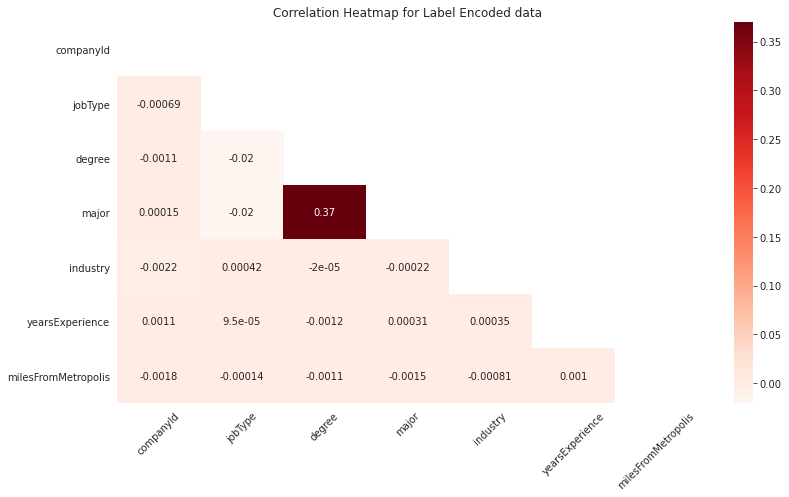

In [17]:
figure = plt.figure(figsize = (13,7))
le_corr = le_Xtrain.corr()
mask = np.triu(np.ones_like(le_corr, dtype= bool))
sns.heatmap(data= le_corr, annot = True, cmap = 'Reds', mask = mask)
plt.xticks(rotation = 45)
plt.title('Correlation Heatmap for Label Encoded data')
plt.show()

In [18]:
X_train.head()

,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
900822,COMP45,JUNIOR,BACHELORS,PHYSICS,SERVICE,16,59
94221,COMP51,VICE_PRESIDENT,MASTERS,PHYSICS,HEALTH,11,47
793011,COMP60,SENIOR,NONE,NONE,AUTO,20,2
902499,COMP62,CEO,MASTERS,NONE,SERVICE,13,33
605932,COMP5,JUNIOR,DOCTORAL,MATH,FINANCE,23,20


In [19]:
le_Xtrain.head()

,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
900822,40,4,0,8,5,16,59
94221,47,7,3,8,3,11,47
793011,57,6,4,7,0,20,2
902499,59,0,3,7,5,13,33
605932,45,4,1,6,2,23,20


## 4. *Implement* and *score* models <a name = "fitscore"></a>

- LinearRegression
- RandomForestRegressor
- Gradient Boosting Regressor
- XGBoost

In [20]:
lr = LinearRegression(n_jobs = -1)
lr2 = LinearRegression(n_jobs = -1)

In [21]:
rf = RandomForestRegressor(n_estimators= 50, n_jobs = -1, random_state= 42,
                           max_depth= 10, min_samples_split= 50)
rf2 = RandomForestRegressor(n_estimators= 50, n_jobs = -1, random_state= 42,
                           max_depth= 10, min_samples_split= 50)

In [22]:
gbr = GradientBoostingRegressor(n_estimators= 50, random_state= 42,
                           max_depth= 10, min_samples_split= 20)
gbr2 = GradientBoostingRegressor(n_estimators= 50, random_state= 42,
                           max_depth= 10, min_samples_split= 20)

In [23]:
lgbr = LGBMRegressor(n_jobs = -1, random_state= 42, n_estimators= 50, max_depth= 10, min_split_gain= 5)
lgbr2 = LGBMRegressor(n_jobs = -1, random_state= 42, n_estimators= 50, max_depth= 10, min_split_gain= 5)

In [24]:
xgbr = XGBRegressor(random_state= 42, n_jobs= -1)
xgbr2 = XGBRegressor(random_state= 42, n_jobs= -1)

## Use Linear Regression as Base Model

In [25]:
lr_baseline_mse = cross_val_score(lr, le_Xtrain, y_train, scoring = 'neg_mean_squared_error')
lr_baseline_mse = -1*lr_baseline_mse.mean()
print("Baseline MSE Score: ", lr_baseline_mse)

Baseline MSE Score:  924.902372798909


**Summary**: By simply *label encoding* the data, one can predict salaries with an **error** of **924.90 dollars squared**.

## Store models in a list for pipeline to run through
- Pipe1: contains a One Hot Encoder and Ordinal Encoder
- Pipe2: contains *only* a One Hot Encoder

In [26]:
ohe = OneHotEncoder(drop= 'first', sparse= False)
oe = OrdinalEncoder()

In [27]:
transformer1 = [('ohe', ohe, ['companyId', 'major', 'industry']),
                ('oe', oe, ['jobType', 'degree'])]
transformer2 = [('ohe', ohe, ['companyId', 'major', 'industry', 'jobType', 'degree'])]

In [28]:
preprocess_transformer = ColumnTransformer(transformers= transformer1, remainder= 'passthrough')
preprocess_transformer2 = ColumnTransformer(transformers= transformer2, remainder= 'passthrough')

## Create 2 types of pipelines for both pipe1 and pipe2

## Pipeline 1 for all Models

In [29]:
pipe1_lr = Pipeline(
    [
        ('preprocess_1', preprocess_transformer),
        ('lr', lr)
    ]
)
pipe1_rf = Pipeline(
    [
        ('preprocess_1', preprocess_transformer),
        ('rf', rf)
    ]
)
pipe1_gbr = Pipeline(
    [
        ('preprocess_1', preprocess_transformer),
        ('gbr', gbr)
    ]
)
pipe1_lgbr = Pipeline(
    [
        ('preprocess_1', preprocess_transformer),
        ('lgbr', lgbr)
    ]
)
pipe1_xgbr = Pipeline(
    [
        ('preprocess_1', preprocess_transformer),
        ('xgbr', xgbr)
    ]
)

## Pipeline 2 for all Models

In [30]:
pipe2_lr = Pipeline(
    [
        ('preprocess_2', preprocess_transformer2),
        ('lr', lr2)
    ]
)
pipe2_rf = Pipeline(
    [
        ('preprocess_2', preprocess_transformer2),
        ('rf', rf2)
    ]
)
pipe2_gbr = Pipeline(
    [
        ('preprocess_2', preprocess_transformer2),
        ('gbr', gbr2)
    ]
)
pipe2_lgbr = Pipeline(
    [
        ('preprocess_2', preprocess_transformer2),
        ('lgbr', lgbr2)
    ]
)
pipe2_xgbr = Pipeline(
    [
        ('preprocess_2', preprocess_transformer2),
        ('xgbr', xgbr2)
    ]
)

# Understanding Feature Importances by model type

# Linear Regression <a name = "lr"></a>

In [31]:
lr_score1 = fitscore(pipe1_lr, X_train, y_train, X_valid, y_valid, cv= 3)

In [32]:
lr_score2 = fitscore(pipe2_lr, X_train, y_train, X_valid, y_valid, cv=3)

In [33]:
#Check if we stil need it
linear1_importance = FeatureImportance(pipe1_lr)
linear2_importance = FeatureImportance(pipe2_lr)

## Summary of Linear Regression Pipeline1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning:

Transformer oe (type OrdinalEncoder) does not provide get_feature_names. Will return input column names if available

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning:

Transformer oe (type OrdinalEncoder) does not provide get_feature_names. Will return input column names if available

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

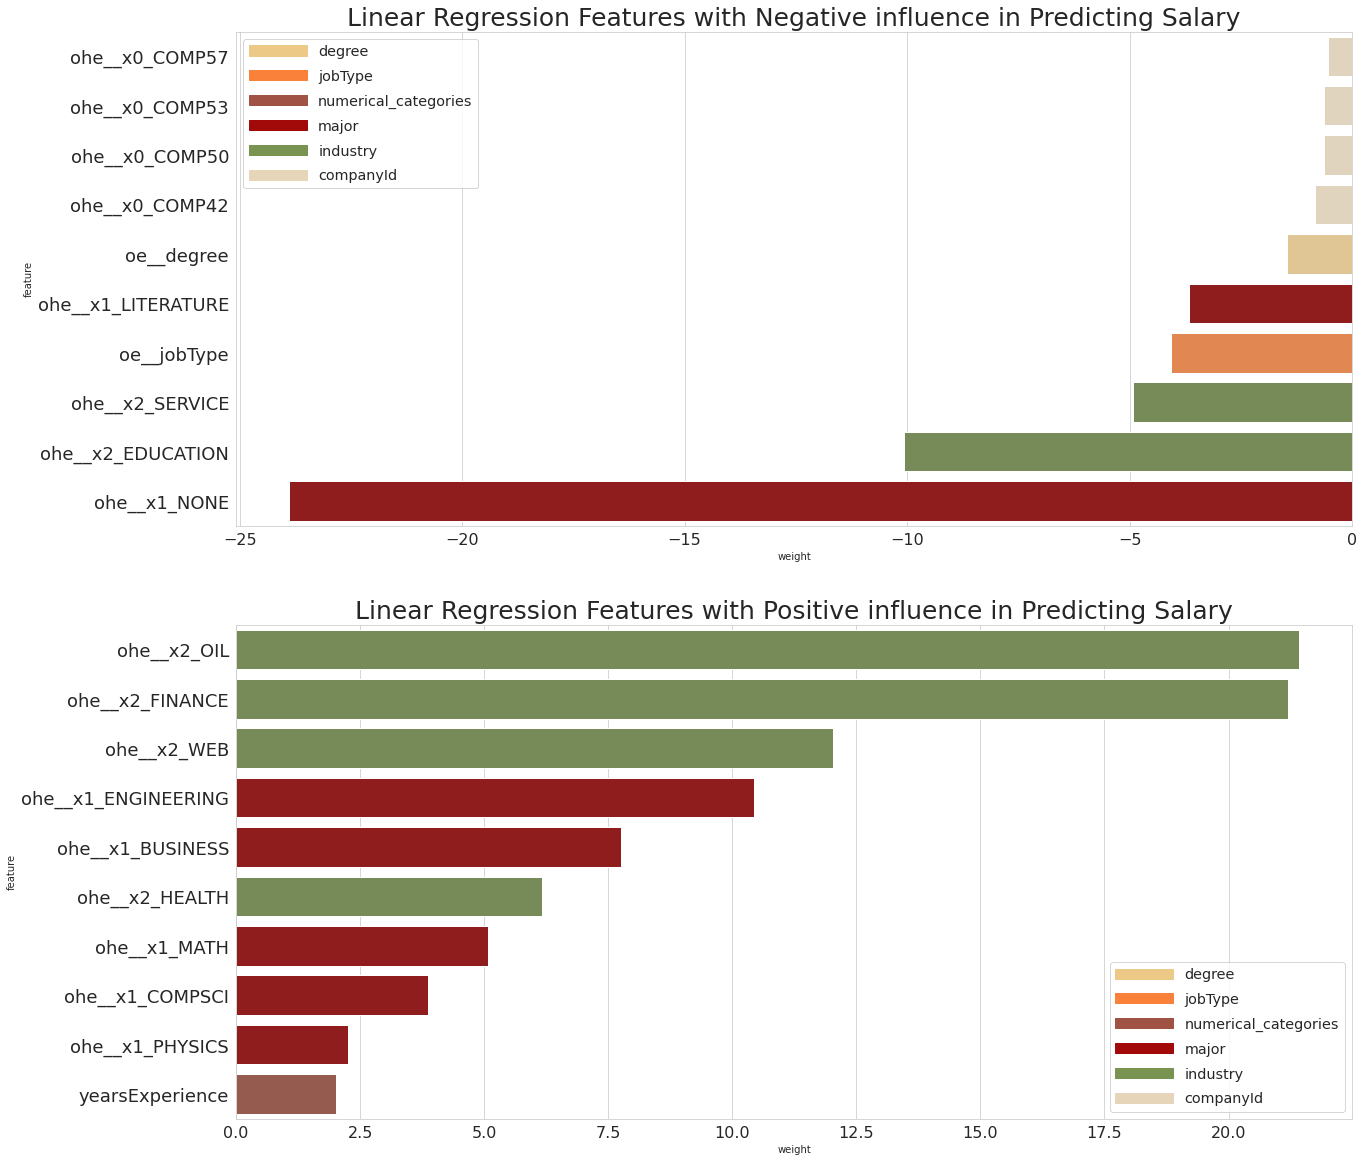

In [34]:
lr1 = feature_vizz(pipe1_lr, 10)

**Summary:** Since this is a *Linear Regression model*, weights will be determined by which features added the **most signal** in predicting Salary.
- The **TOP 3 positive features** the model indentified were ***ALL "industries":***
    - Oil 
    - Finance
    - Web

- The **TOP 3 negative features** the model identified were ***mostly "industries":***
    - Service
    - Education
    - (Major) is None; the *exception* with the **greatest negative influence** on predicting salary

### Save Figure and Pipeline

In [35]:
#Figure
lr1.figure.savefig(PATH + '/Graphs/lr1.png', dpi=300, bbox_inches='tight')
#Pipeline
joblib.dump(pipe1_gbr, PATH + PIPE1 + 'pipe1_lr.joblib')

['/content/drive/My Drive/Salary Prediction Project/Joblib Pipelines/Pipeline1/pipe1_lr.joblib']

## Summary of Linear Regression Pipeline2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



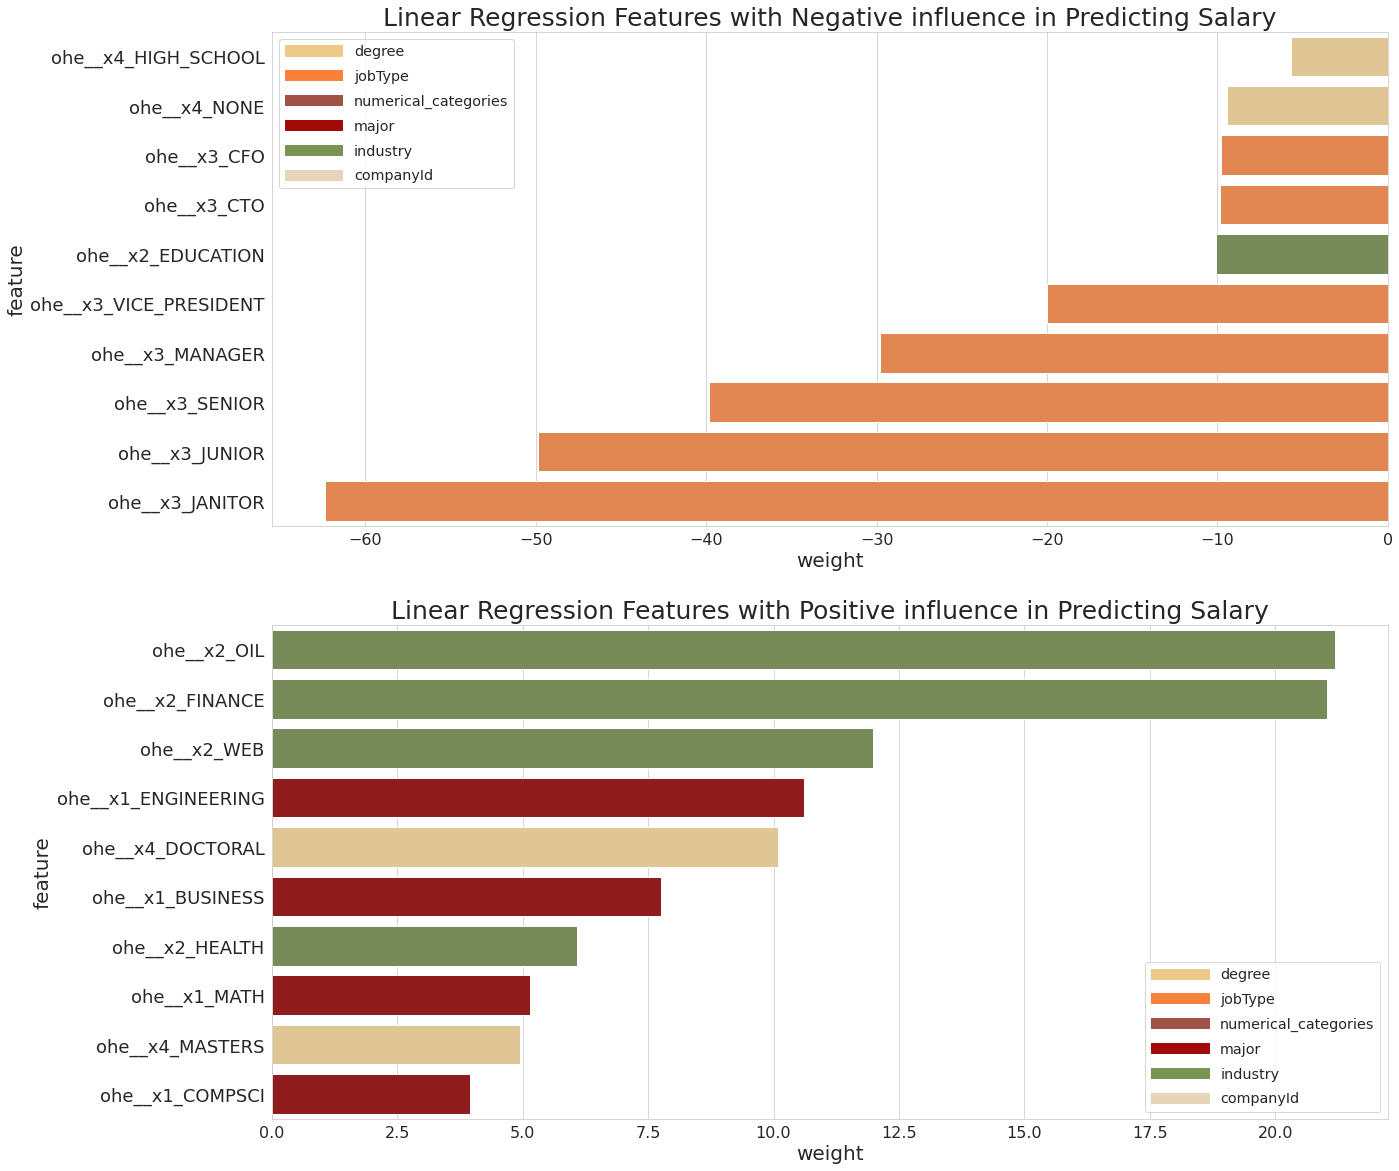

In [36]:
lr2 = feature_vizz(pipe2_lr, 10)

**Summary:** Since this is a *Linear Regression model*, weights will be determined by which features added the **most signal** in predicting Salary.
- The **TOP 3 positive features** the model indentified were ***ALL "industries":***
    - Oil 
    - Finance
    - Web

- The **TOP 3 negative features** the model identified were ***ALL "jobTypes":***
    - Janitor
    - Junior
    - Senior

### Save Figure and Pipeline

In [37]:
#Figure
lr2.figure.savefig(PATH + '/Graphs/lr2.png', dpi=300, bbox_inches='tight')
#Pipeline
joblib.dump(pipe2_lr, PATH + PIPE1 + 'pipe1_lr.joblib')

['/content/drive/My Drive/Salary Prediction Project/Joblib Pipelines/Pipeline1/pipe1_lr.joblib']

# Random Forest

In [38]:
rf_score1 = fitscore(pipe1_rf, X_train, y_train, X_valid, y_valid, cv= 3)

In [39]:
rf_score2 = fitscore(pipe2_rf, X_train, y_train, X_valid, y_valid, cv= 3)

In [40]:
rf1_importance = FeatureImportance(pipe1_rf)
rf2_importance = FeatureImportance(pipe2_rf)

## Summary of Random Forest Pipeline1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning:

Transformer oe (type OrdinalEncoder) does not provide get_feature_names. Will return input column names if available



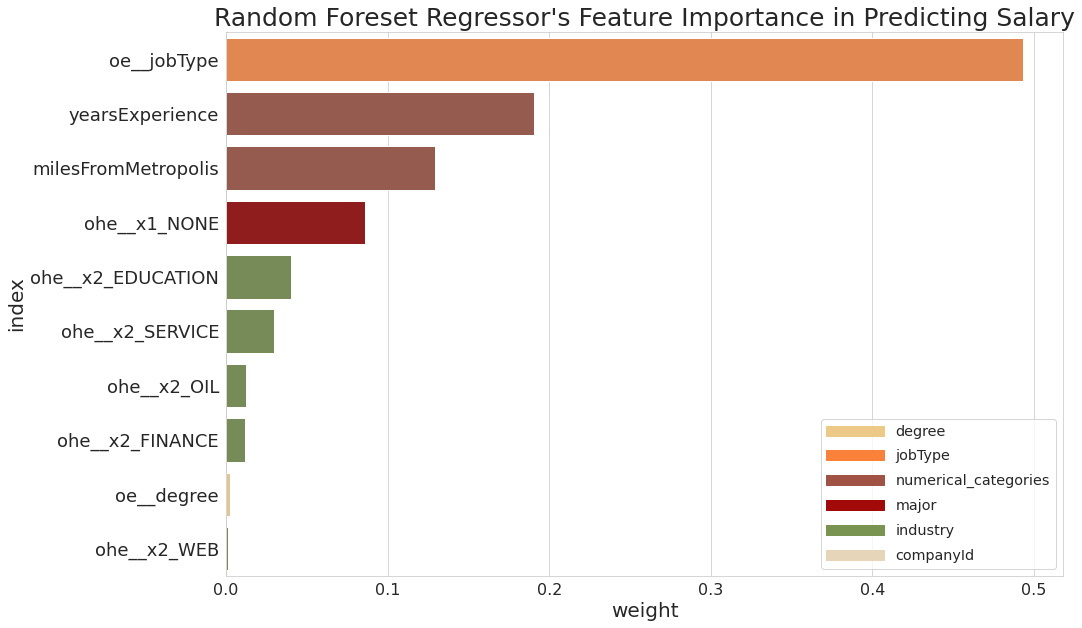

In [41]:
rf1 = feature_vizz(pipe1_rf, 10)

**Summary:** 
- Since this is a *Random Forest regressor*, weights will be determined by which features added the **most signal** in predicting salary from its individual decision trees. 
- The model indentifies 3 features with significant predictive signal **(> 10% weight):**
    - The *Ordinal Encoded* **"jobType feature** which provided **almost 50% signal** in predicting salary
    - **2 are the "numerical categories"**; (*Combined Signal ~20%*)
        - "YearsExperience"
        - "milesFromMetropolis" 


### Save Figure and Pipeline

In [42]:
#Figure
rf1.figure.savefig(PATH + '/Graphs/rf1.png', dpi=300, bbox_inches='tight')
#Pipeline
joblib.dump(pipe1_rf, PATH + PIPE1 + 'pipe1_rf.joblib')

['/content/drive/My Drive/Salary Prediction Project/Joblib Pipelines/Pipeline1/pipe1_rf.joblib']

## Summary of Random Forest Pipeline2

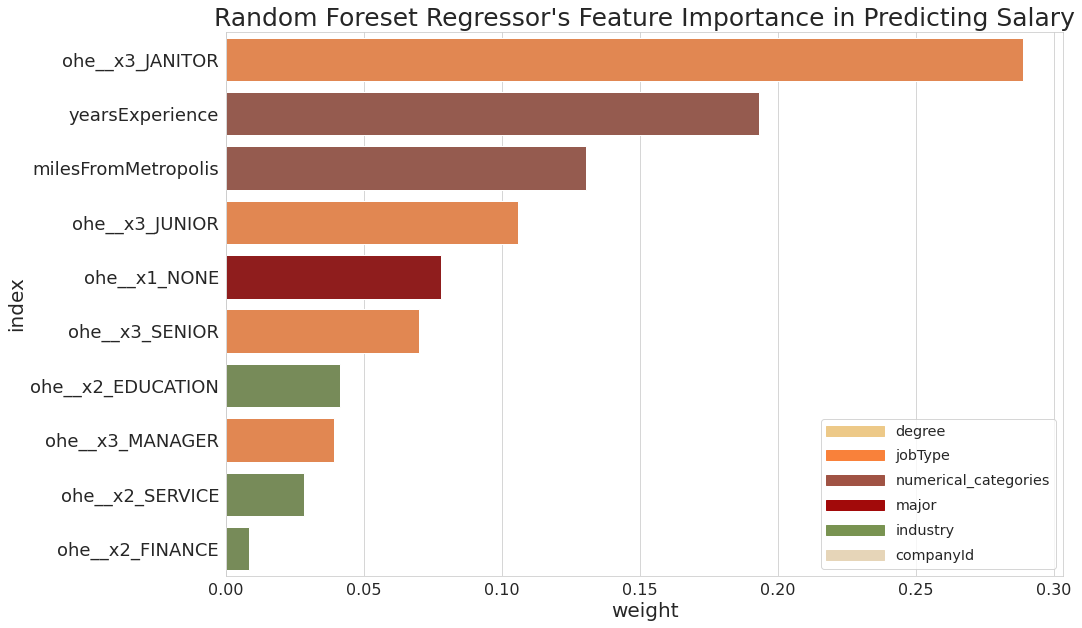

In [43]:
rf2 = feature_vizz(pipe2_rf, 10)

**Summary:** 
- Since this is a *Random Forest regressor*, weights will be determined by which features added the **most signal** in predicting salary from its individual decision trees. 
- The model indentifies *4 features* with significant predictive signal **(> 10% weight):**
    - **2 "jobType(s)"**:
        - Janitor (*Greatest signal: ~ >25%*)
        - Junior 
    - **2 are the "numerical categories"**; (*Combined Signal ~30%*)
        - "YearsExperience"
        - "milesFromMetropolis" 

### Save Figure and Pipeline

In [44]:
#Figure
rf2.figure.savefig(PATH + '/Graphs/rf2.png', dpi=300, bbox_inches='tight')
#Pipeline
joblib.dump(pipe2_rf, PATH + PIPE2 + 'pipe2_rf.joblib')

['/content/drive/My Drive/Salary Prediction Project/Joblib Pipelines/Pipeline2/pipe2_rf.joblib']

# Gradient Boosting Regressor

In [45]:
gbr_score1 = fitscore(pipe1_gbr, X_train, y_train, X_valid, y_valid, cv= 3)

In [46]:
gbr_score2 = fitscore(pipe2_gbr, X_train, y_train, X_valid, y_valid, cv= 3)

In [47]:
gbr1_importance = FeatureImportance(pipe1_gbr)
gbr2_importance = FeatureImportance(pipe2_gbr)

## Summary of Gradient Boosting Regressor Pipeline1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning:

Transformer oe (type OrdinalEncoder) does not provide get_feature_names. Will return input column names if available



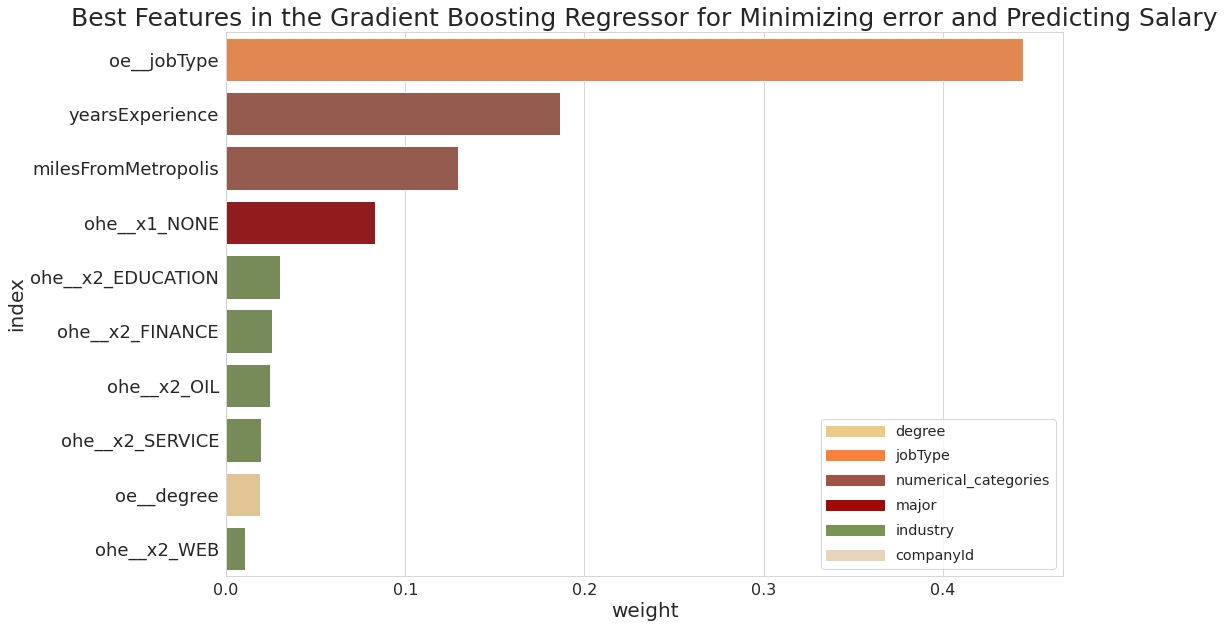

In [48]:
gbr1 = feature_vizz(pipe1_gbr, 10)

**Summary:** 
- Since this is a *Gradient Boosting regressor*, weights will be determined by which weak learners can be improved to **reduce error** and provide **more signal** in predicting salary. 
- The model indentifies **3 features** with significant predictive signal **(> 10% weight):**
    - The *Ordinal Encoded* **"jobType feature** which, when boosted, provides **~ 45% signal** in predicting salary
    - **2 are the "numerical categories"**; (*Combined Signal ~30%*)
        - "YearsExperience"
        - "milesFromMetropolis" 

### Save Figure and Pipeline

In [49]:
#Figure
gbr1.figure.savefig(PATH + '/Graphs/gbr1.png', dpi=300, bbox_inches='tight')
#Pipeline
joblib.dump(pipe1_gbr, PATH + PIPE1 + 'pipe1_gbr.joblib')

['/content/drive/My Drive/Salary Prediction Project/Joblib Pipelines/Pipeline1/pipe1_gbr.joblib']

## Summary of Gradient Boosting Regressor Pipeline2

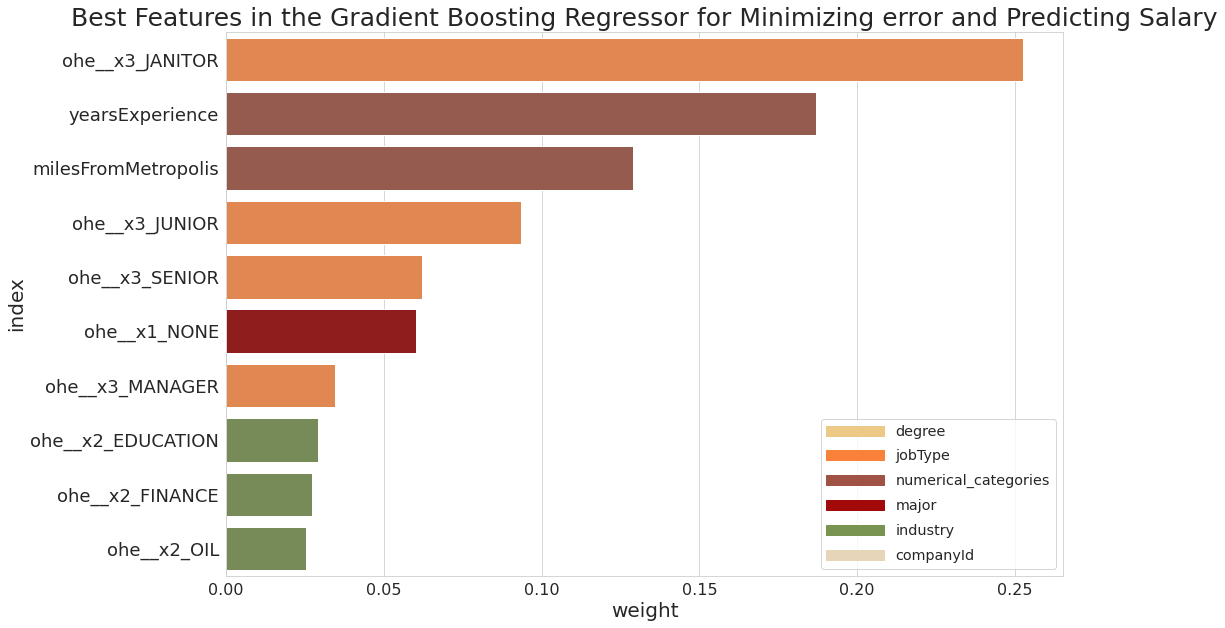

In [50]:
gbr2 = feature_vizz(pipe2_gbr, 10)

**Summary:**
- Since this is a *Gradient Boosting regressor*, weights will be determined by which weak learners can be improved to **reduce error** and provide **more signal** in predicting salary. 
- The model indentifies **3 features** with significant predictive signal **(> 10% weight):**
    - The *Janitor* **"jobType feature**: which, when boosted, provides **~ 25% signal** in predicting salary
    - **2 are the "numerical categories"**; (*Combined Signal ~30%*)
        - "YearsExperience"
        - "milesFromMetropolis" 

### Save Figure and Model

In [51]:
#Figure
gbr2.figure.savefig(PATH + '/Graphs/gbr2.png', dpi=300, bbox_inches='tight')
#Pipeline
joblib.dump(pipe2_gbr, PATH + PIPE2 + 'pipe2_gbr.joblib')

['/content/drive/My Drive/Salary Prediction Project/Joblib Pipelines/Pipeline2/pipe2_gbr.joblib']

# Light Gradient Boosting Regressor

In [52]:
lgbr_score1 = fitscore(pipe1_lgbr, X_train, y_train, X_valid, y_valid, cv= 3)

In [53]:
lgbr_score2 = fitscore(pipe2_lgbr, X_train, y_train, X_valid, y_valid, cv= 3)

In [54]:
lgbr1_importance = FeatureImportance(pipe1_lgbr)
lgbr2_importance = FeatureImportance(pipe2_lgbr)

## Summary of Light Gradient Boosting Regressor Pipeline1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning:

Transformer oe (type OrdinalEncoder) does not provide get_feature_names. Will return input column names if available



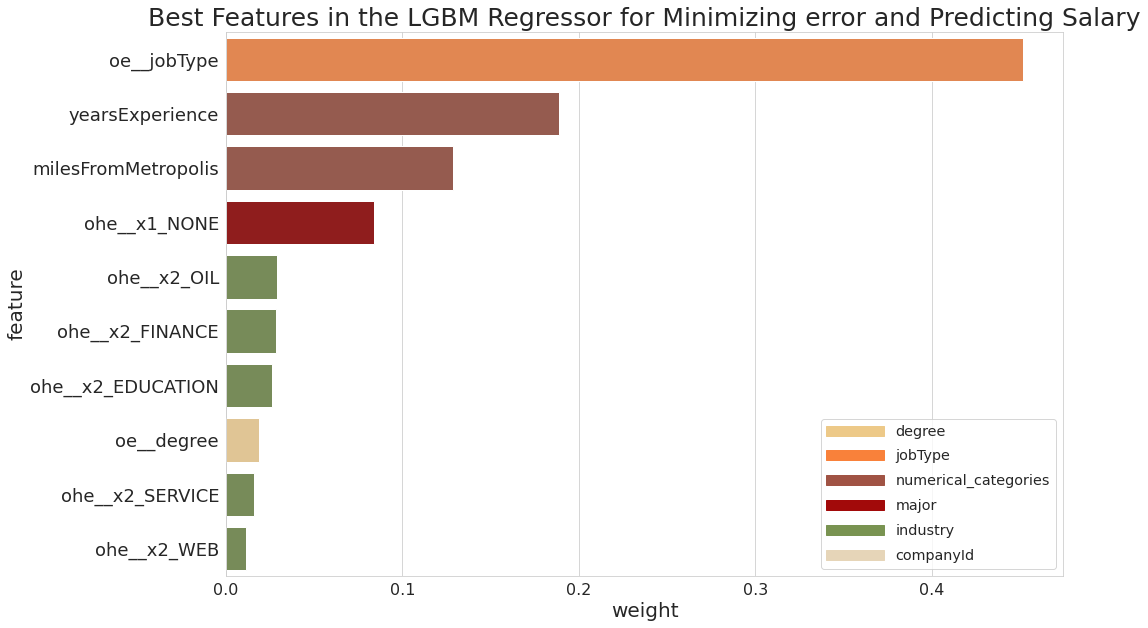

In [55]:
lgbr1 = feature_vizz(pipe1_lgbr, 10)

**Summary:** 
- Since this is a *Light Gradient Boosting regressor*, weights will be determined by which weak learners can be improved to **reduce error** and provide **more signal** in predicting salary. 
- The model indentifies **3 features** with significant predictive signal **(> 10% weight):**
    - The *Ordinal Encoded* **"jobType feature**: which, when boosted, provides **~ 45% signal** in predicting salary
    - There are **2 "numerical categories"**; (*Combined Signal ~30%*)
        - "YearsExperience"
        - "milesFromMetropolis" 

### Save Figure and Pipeline

In [56]:
#Figure
lgbr1.figure.savefig(PATH + '/Graphs/lgbr1.png', dpi=300, bbox_inches='tight')
#Pipeline
joblib.dump(pipe1_lgbr, PATH + PIPE1 +'pipe1_lgbr.joblib')

['/content/drive/My Drive/Salary Prediction Project/Joblib Pipelines/Pipeline1/pipe1_lgbr.joblib']

## Summary of Light Gradient Boosting Regressor Pipeline2

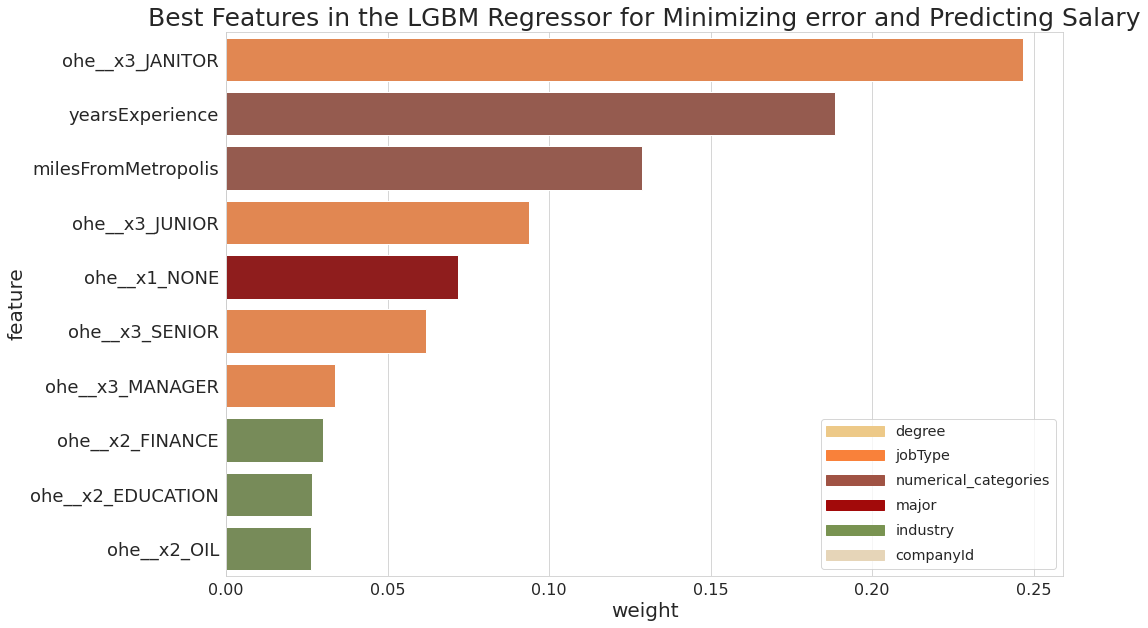

In [57]:
lgbr2 = feature_vizz(pipe2_lgbr, 10)

**Summary:** 
- Since this is a *Light Gradient Boosting regressor*, weights will be determined by which weak learners can be improved to **reduce error** and provide **more signal** in predicting salary. 
- The model indentifies **3 features** with significant predictive signal **(> 10% weight):**
    - The *Janitor* **"jobType feature**: which, when boosted, provides **~ 45% signal** in predicting salary
    - **2 are the "numerical categories"**; (*Combined Signal ~30%*)
        - "YearsExperience"
        - "milesFromMetropolis" 

### Save Figure and Pipeline

In [59]:
#Figure
lgbr2.figure.savefig(PATH + '/Graphs/lgbr2.png', dpi=300, bbox_inches='tight')
#Pipeline
joblib.dump(pipe2_lgbr, PATH + PIPE2 +'pipe2_lgbr.joblib')

['/content/drive/My Drive/Salary Prediction Project/Joblib Pipelines/Pipeline2/pipe2_lgbr.joblib']

# XGB Regressor

In [60]:
xgbr_score1 = fitscore(pipe1_xgbr, X_train, y_train, X_valid, y_valid, cv= 3)

[22:51:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:53:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:53:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:53:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [61]:
xgbr_score2 = fitscore(pipe2_xgbr, X_train, y_train, X_valid, y_valid, cv= 3)

[22:54:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:56:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:56:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:56:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [62]:
xgbr1_importance = FeatureImportance(pipe1_xgbr)
xgbr2_importance = FeatureImportance(pipe2_xgbr)

## Summary of XGB Regressor Pipeline1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning:

Transformer oe (type OrdinalEncoder) does not provide get_feature_names. Will return input column names if available



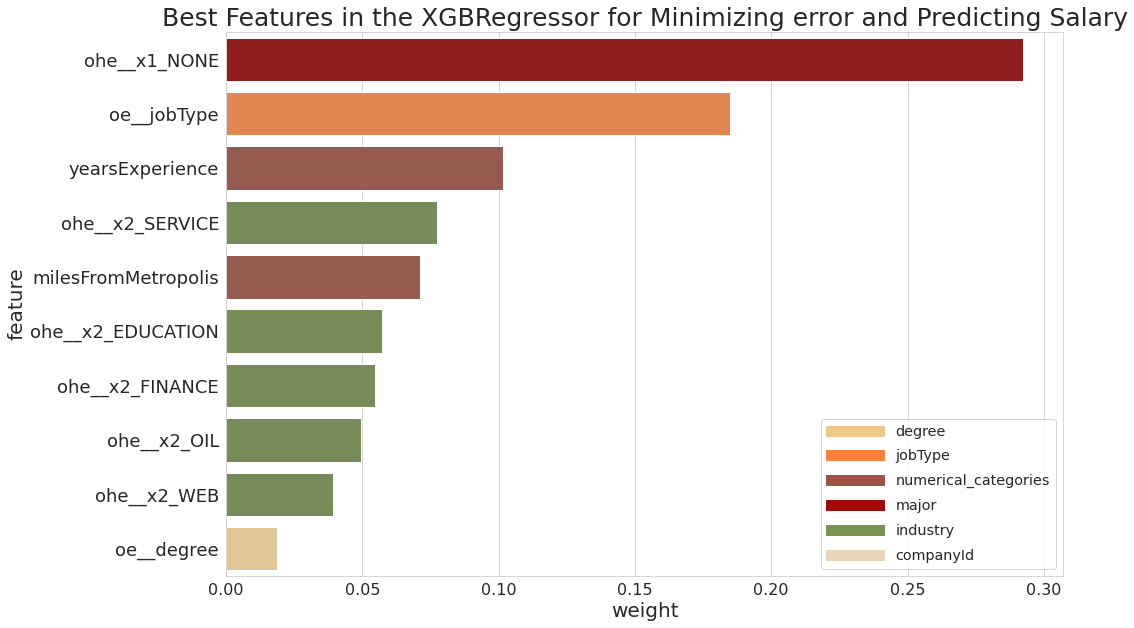

In [63]:
xgbr1 = feature_vizz(pipe1_xgbr, 10)

**Summary:** 
- Since this is a *XGB regressor*, weights will be determined by which weak learners can be improved to **reduce error** and provide **more signal** in predicting salary. 
- The model indentifies **3 different features** with significant predictive signal **(> 10% weight):**
    - The **NONE major feature** provides (**~30% signal**)
    - The *Ordinal Encoded* **"jobType feature** provides (**~ 18% signal**)
    - The **yearsExperience** feature from **"numerical categories"**, provides (**~10% signal**)

### Save Figure and Pipeline

In [64]:
#Figure
xgbr1.figure.savefig(PATH + '/Graphs/xgbr1.png', dpi=300, bbox_inches='tight')
#Pipeline
joblib.dump(pipe1_xgbr, PATH + PIPE1 + 'pipe1_xgbr.joblib')

['/content/drive/My Drive/Salary Prediction Project/Joblib Pipelines/Pipeline1/pipe1_xgbr.joblib']

## Summary of XGB Regressor Pipeline2

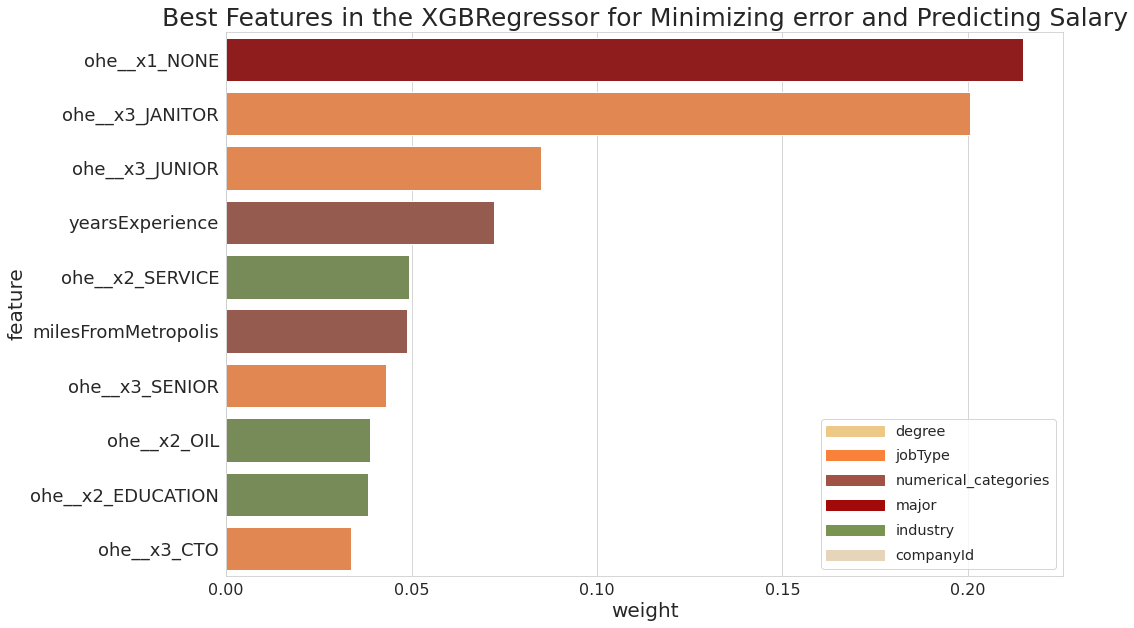

In [65]:
xgbr2 = feature_vizz(pipe2_xgbr, 10)

**Summary:** 
- Since this is a *XGB regressor*, weights will be determined by which weak learners can be improved to **reduce error** and provide **more signal** in predicting salary. 
- The model indentifies **2 different features** with significant predictive signal **(> 10% weight):**
    - The **NONE major feature** provides (**~22% signal**)
    - The *Janitor* **"jobType feature** provides (**~ 20% signal**)

### Save Figure and Pipeline

In [66]:
#Figure
xgbr2.figure.savefig(PATH + '/Graphs/xgbr2.png', dpi=300, bbox_inches='tight')
#Pipeline
joblib.dump(pipe2_xgbr, PATH + PIPE2 +'pipe2_xgbr.joblib')

['/content/drive/My Drive/Salary Prediction Project/Joblib Pipelines/Pipeline2/pipe2_xgbr.joblib']

## 5. <i>Visualize</i> Results of Base Model scores for *both* pipelines<a name = "base"></a>

In [67]:
model_names = ['LinearRegression', 'RandomForestRegressor', 
               'GradientBoostingRegressor', 'LightGBMRegressor', 'XGBRegressor']
pipe1_scores = [lr_score1, rf_score1, gbr_score1, lgbr_score1, xgbr_score1]
pipe2_scores = [lr_score2, rf_score2, gbr_score2, lgbr_score2, xgbr_score2]

pipe1_dict = dict(zip(model_names, pipe1_scores))
pipe2_dict = dict(zip(model_names, pipe2_scores))

In [68]:
pipe_base_scores = pd.DataFrame([pipe1_dict, pipe2_dict])

In [69]:
pipe_base_scores = pipe_base_scores.T
pipe_base_scores.columns = ['pipe1_scores', 'pipe2_scores']
pipe_base_scores

,pipe1_scores,pipe2_scores
LinearRegression,720.050016,384.761351
RandomForestRegressor,421.063173,460.364835
GradientBoostingRegressor,369.050381,367.194831
LightGBMRegressor,370.159996,372.417657
XGBRegressor,378.757320,394.983935


(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

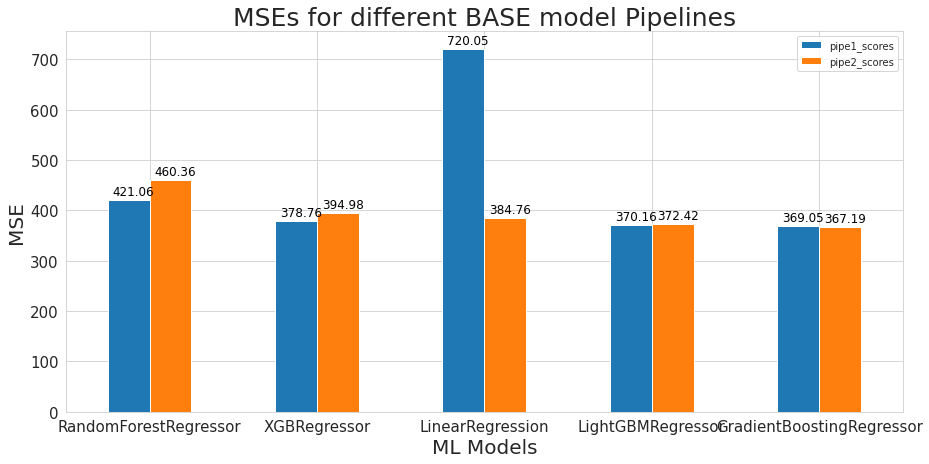

In [70]:
f, ax = plt.subplots(1, 1, figsize=(15, 7))
pipe_base_scores.sort_values(by = 'pipe2_scores', ascending = False).plot(kind = 'bar', ax = ax)

# set individual bar labels
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+ 0.03, i.get_height()+ 10, str(round((i.get_height()), 2)), fontsize=12, color='black')

#set size of x and y tick labels
for ticklabel in (ax.get_xticklabels()):
    ticklabel.set_fontsize(15)
for ticklabel in (ax.get_yticklabels()):
    ticklabel.set_fontsize(15)

plt.title('MSEs for different BASE model Pipelines', fontdict = {'fontsize' : 25})
plt.xlabel('ML Models', fontdict = {'fontsize' : 20})
plt.ylabel('MSE', fontdict = {'fontsize' : 20})
plt.xticks(rotation = 0)

In [71]:
print('Average pipe1 scores was {}'.format(np.mean(pipe_base_scores['pipe1_scores'])))

Average pipe1 scores was 451.81617723520793


In [72]:
print('Average pipe2 scores was {}'.format(np.mean(pipe_base_scores['pipe2_scores'])))

Average pipe2 scores was 395.9445218575483


***Summary:*** 
- The *Gradient Boosting Regressors* - **LightGBM** and **Gradient Boosting** - performed **best** amongst *both* pipelines. 
- The **Random Forest Regressor** performed the **worst** on *average*.
- The **Linear Regressor** in pipeline1 performed very **badly** among *all* the pipe1s

### Save Visualization of Base Model Scores from the Different Pipelines

In [73]:
f.savefig(PATH + '/Graphs/BaseModelComp.png', dpi=300, bbox_inches='tight')

### Save Base Model Scores

In [74]:
with open(PATH + '/Pickle Data/base_scores.pkl', 'wb') as scores:
    pickle.dump(pipe_base_scores, scores)